<a href="https://colab.research.google.com/github/dardenkyle/Stock-Market-Trends---Volatility/blob/main/Stock_Market_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Trends & Volatility Analysis

## Project Information

Stock Market Trends & Volatility Analysis<br>
✅ Skills Used: Python, pandas, Matplotlib/Seaborn, yFinance API, statistics<br>
✅ Time Required: 5-10 hours<br>
✅ Tools: Python, Jupyter Notebook<br>

Project Idea:
* Pull historical stock price data from Yahoo Finance API for Tesla (TSLA), Apple (AAPL), and Bitcoin (BTC).
* Compute daily returns, moving averages, Bollinger Bands, and volatility (standard deviation).
* Visualize stock trends vs. S&P 500 and compare volatility.
* Identify which stock had the highest risk-adjusted returns (Sharpe Ratio).

📌 Example Output: A Jupyter Notebook with time-series plots and summary statistics.

## Importing Necessary Libraries

In [73]:
# Libraries needed
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
import argparse
import logging
import json
import requests
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBClassifier
from sklearn.ensemble import (AdaBoostClassifier,
                              BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              )
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             make_scorer
                             )

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [52]:
# Preventing scientific notation.
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [41]:
tickers = ['AAPL']
#  , 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'NFLX']

stock_data = yf.download(tickers, period='84mo', interval='1d')

# Convert the stock_data to a DataFrame
data = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed


In [127]:
# Creating a copy of the data frame, df, to leave original data unaltered
df = data.copy()

## Data Overview

In [43]:
# Viewing shape of dataframe
df.shape

(1761, 5)

In [44]:
# Viewing top 10 rows of df
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-29,39.512764,40.030316,39.303391,40.030316,202561600
2018-01-30,39.279873,39.373972,38.745852,38.941111,184192800
2018-01-31,39.388084,39.625690,39.169303,39.256344,129915600
2018-02-01,39.470406,39.668016,39.230449,39.326902,188923200
2018-02-02,37.757790,39.239872,37.663691,39.051670,346375200


In [45]:
# Viewing Column Labels
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [46]:
# Information about the data frame's columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-29 to 2025-01-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1761 non-null   float64
 1   (High, AAPL)    1761 non-null   float64
 2   (Low, AAPL)     1761 non-null   float64
 3   (Open, AAPL)    1761 non-null   float64
 4   (Volume, AAPL)  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB


In [48]:
# Checking the data frame for null values.
if df.isnull().values.any():
  print("There are null values.")
else:
  print("There are no null values.")

There are no null values.


In [49]:
# Checking the data frame for duplicate values.
if df.duplicated().any():
    print("There are duplicate values.")
else:
    print("There are no duplicate values.")

There are no duplicate values.


In [53]:
# Statistical summary of the columns with data type of "Int64" and "Float64".
df.describe().T

,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
Close,AAPL,1761.000,124.375,59.866,33.953,58.650,133.931,170.222,259.020
High,AAPL,1761.000,125.612,60.345,34.795,59.276,135.497,171.990,260.100
Low,AAPL,1761.000,122.997,59.294,33.907,57.554,132.114,168.882,257.630
Open,AAPL,1761.000,124.252,59.798,34.380,58.390,133.657,169.955,258.190
Volume,AAPL,1761.000,99522194.919,55295831.853,23234700.000,62128300.000,86264000.000,121047300.000,426510000.000


**Observations**
* obs 1

## Data Preprocessing

In [128]:
# Dropping Ticker Column Label since we are only working with the AAPL stock for now
df = df.droplevel(1, axis=1)

In [129]:
# Checking new column labels
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [130]:
# Checking df to ensure changes are correct
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-29,39.513,40.030,39.303,40.030,202561600
2018-01-30,39.280,39.374,38.746,38.941,184192800
2018-01-31,39.388,39.626,39.169,39.256,129915600
2018-02-01,39.470,39.668,39.230,39.327,188923200
2018-02-02,37.758,39.240,37.664,39.052,346375200


## *EDA*

### Univariate

<Figure size 1000x600 with 0 Axes>

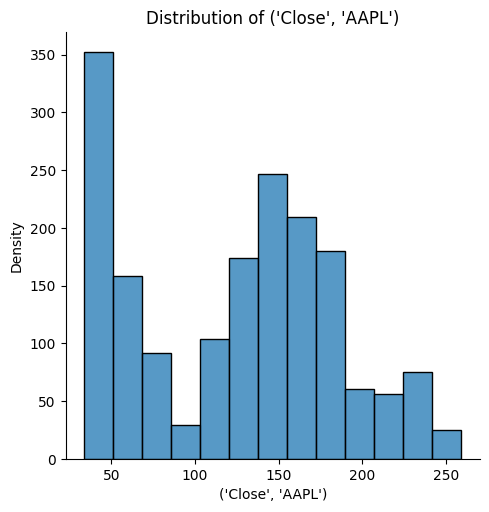

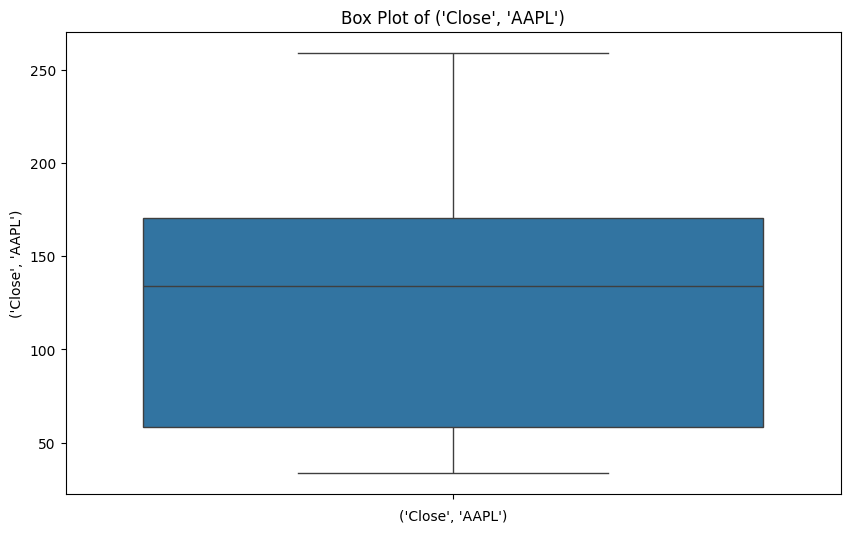

<Figure size 1000x600 with 0 Axes>

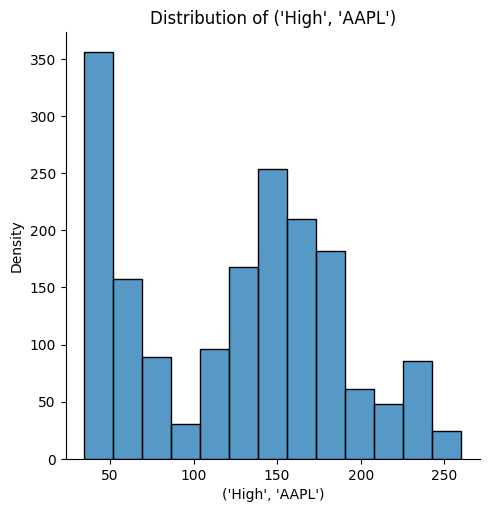

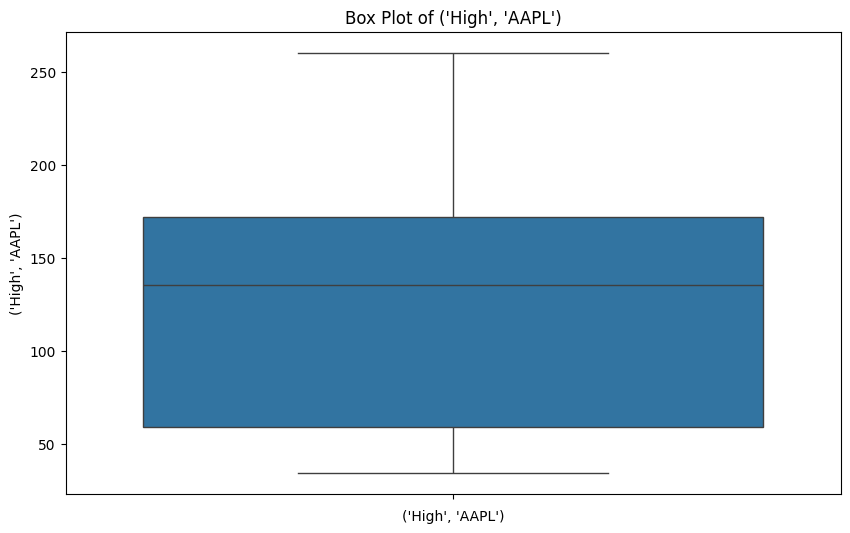

<Figure size 1000x600 with 0 Axes>

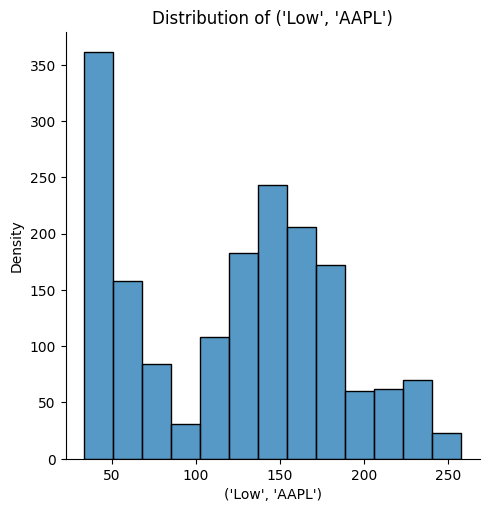

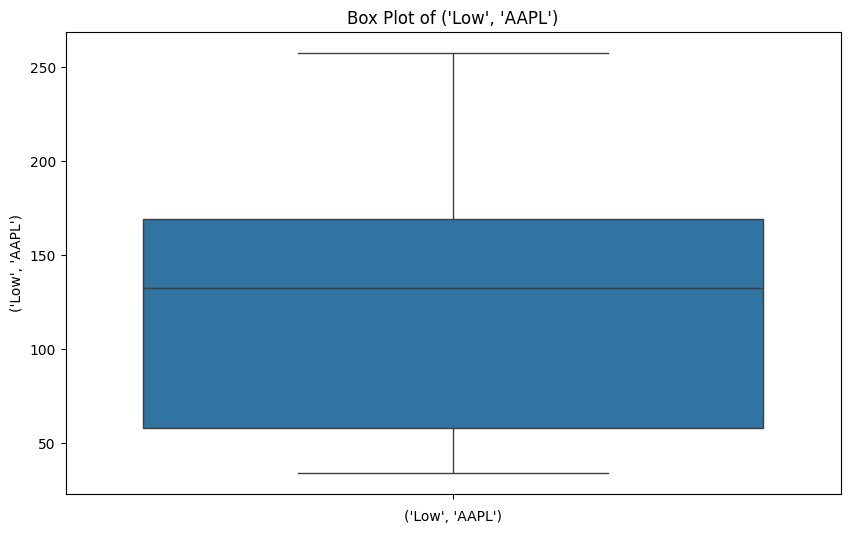

<Figure size 1000x600 with 0 Axes>

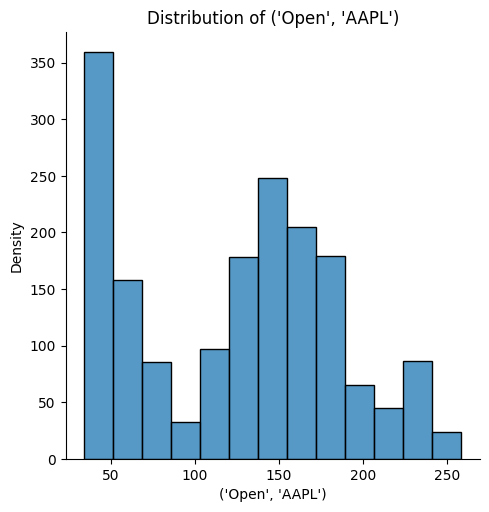

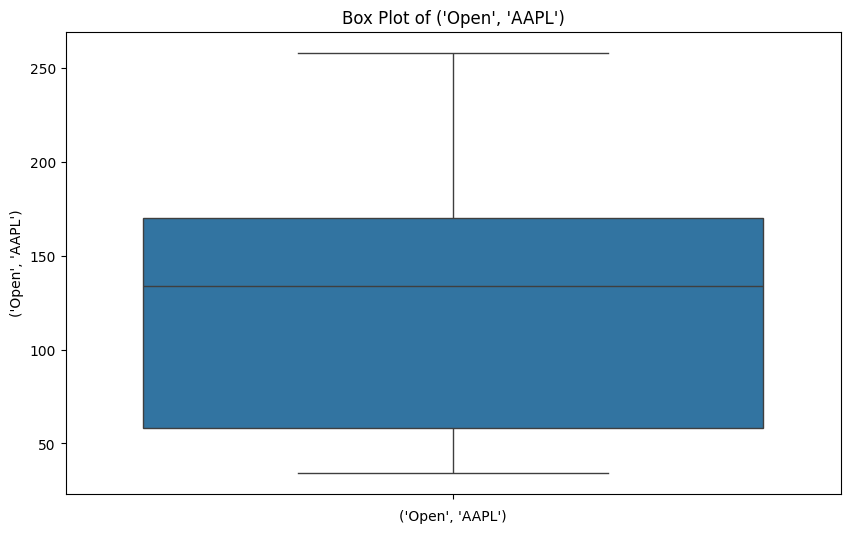

<Figure size 1000x600 with 0 Axes>

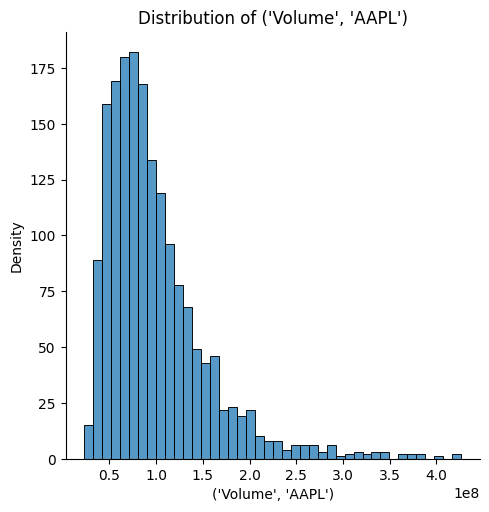

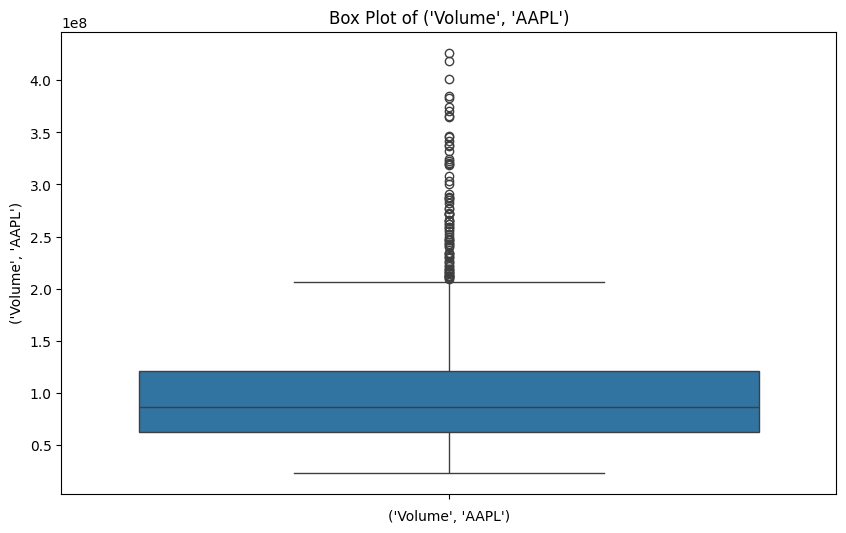

In [18]:
# prompt: generate univariate plots for data analysis

# univariate analysis
def univariate_analysis(df):
    # numerical features
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in num_cols:
        plt.figure(figsize=(10, 6))
        sns.displot(df[col])
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(df[col])
        plt.title(f"Box Plot of {col}")
        plt.xlabel(col)
        plt.show()


    # categorical features (if any)
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Bar Plot of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

univariate_analysis(df)

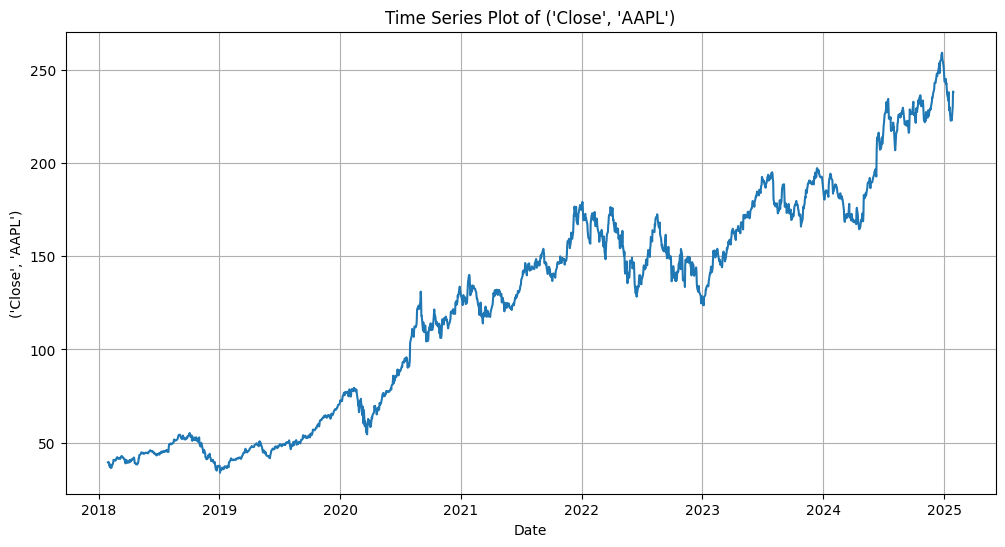

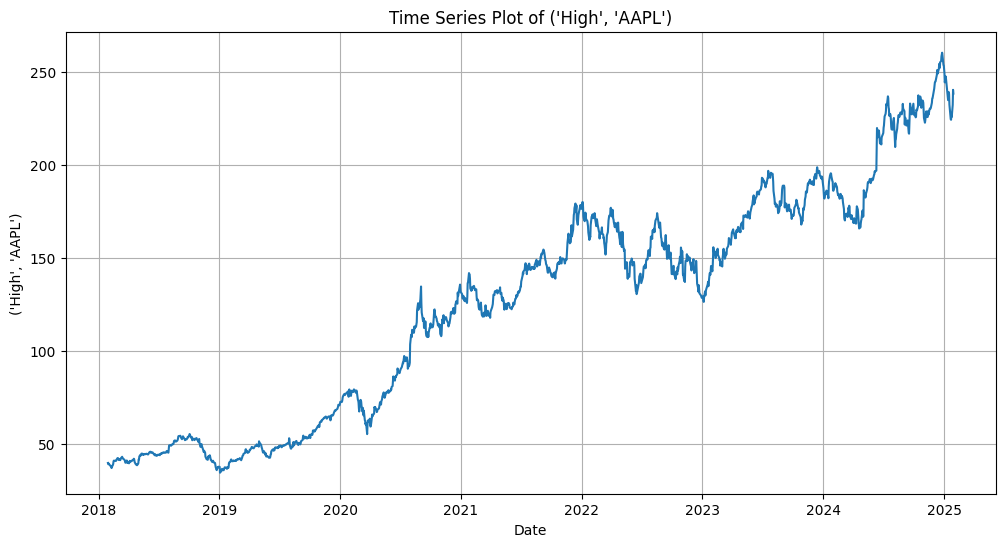

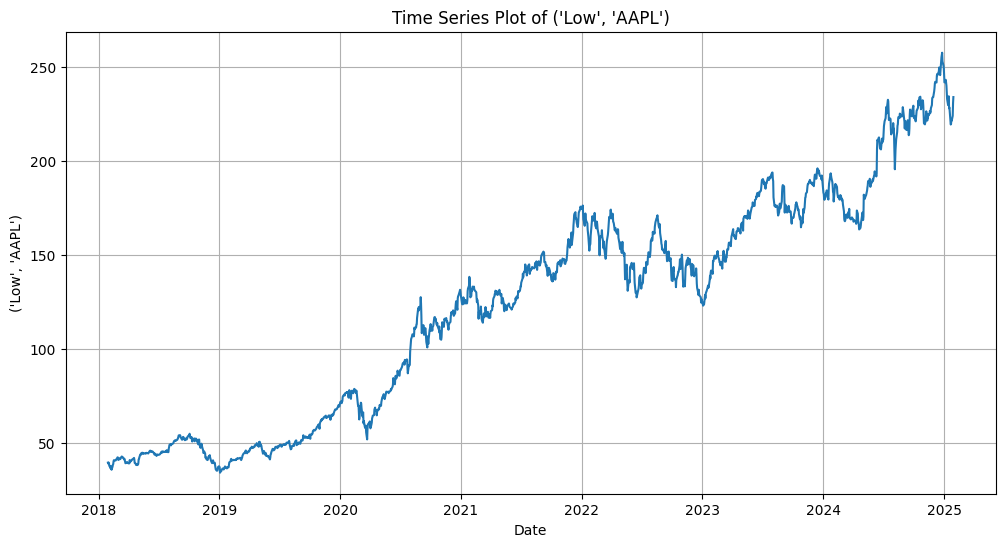

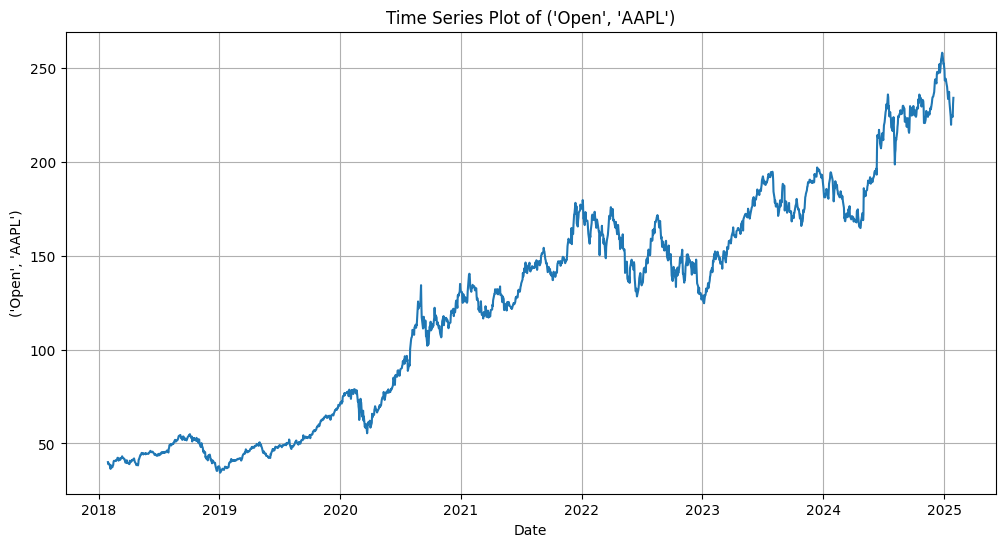

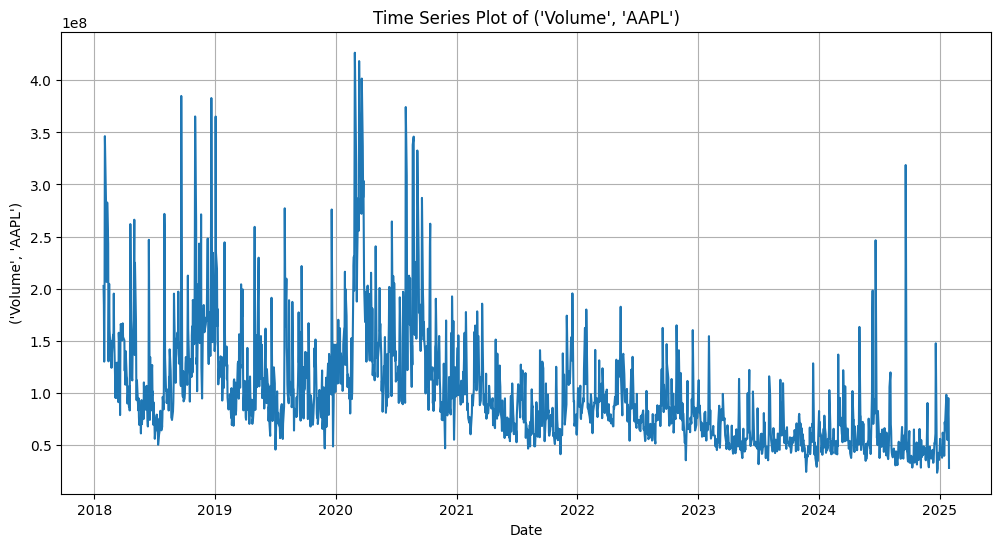

In [20]:
# prompt: time series data for columns

# Time series analysis for each column
def time_series_analysis(df):
    for col in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df[col])
        plt.title(f"Time Series Plot of {col}")
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.grid(True)
        plt.show()

time_series_analysis(df)

### Multivariate


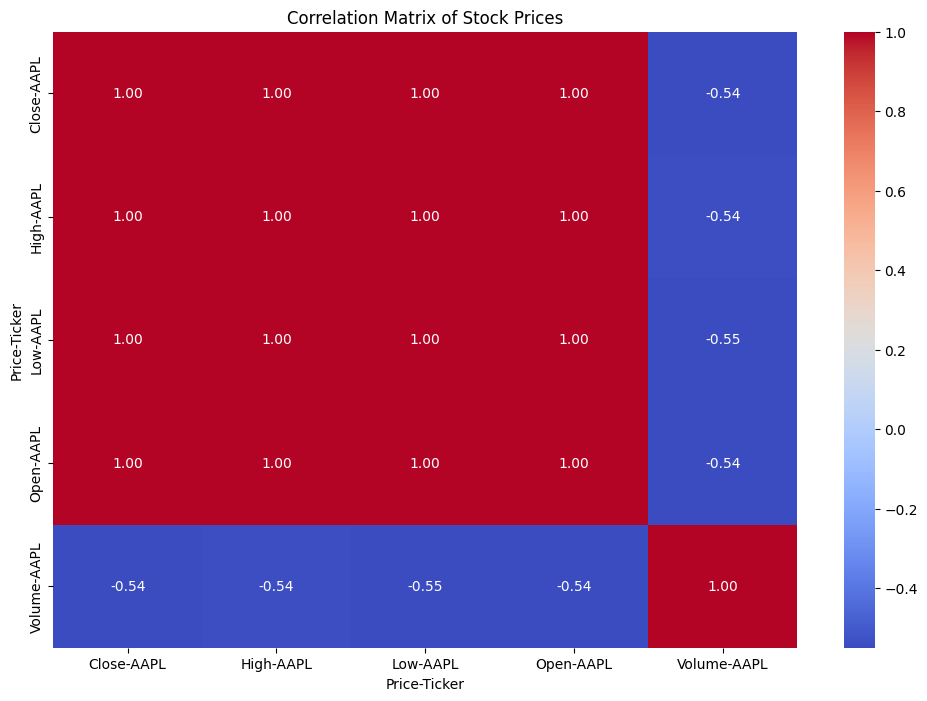

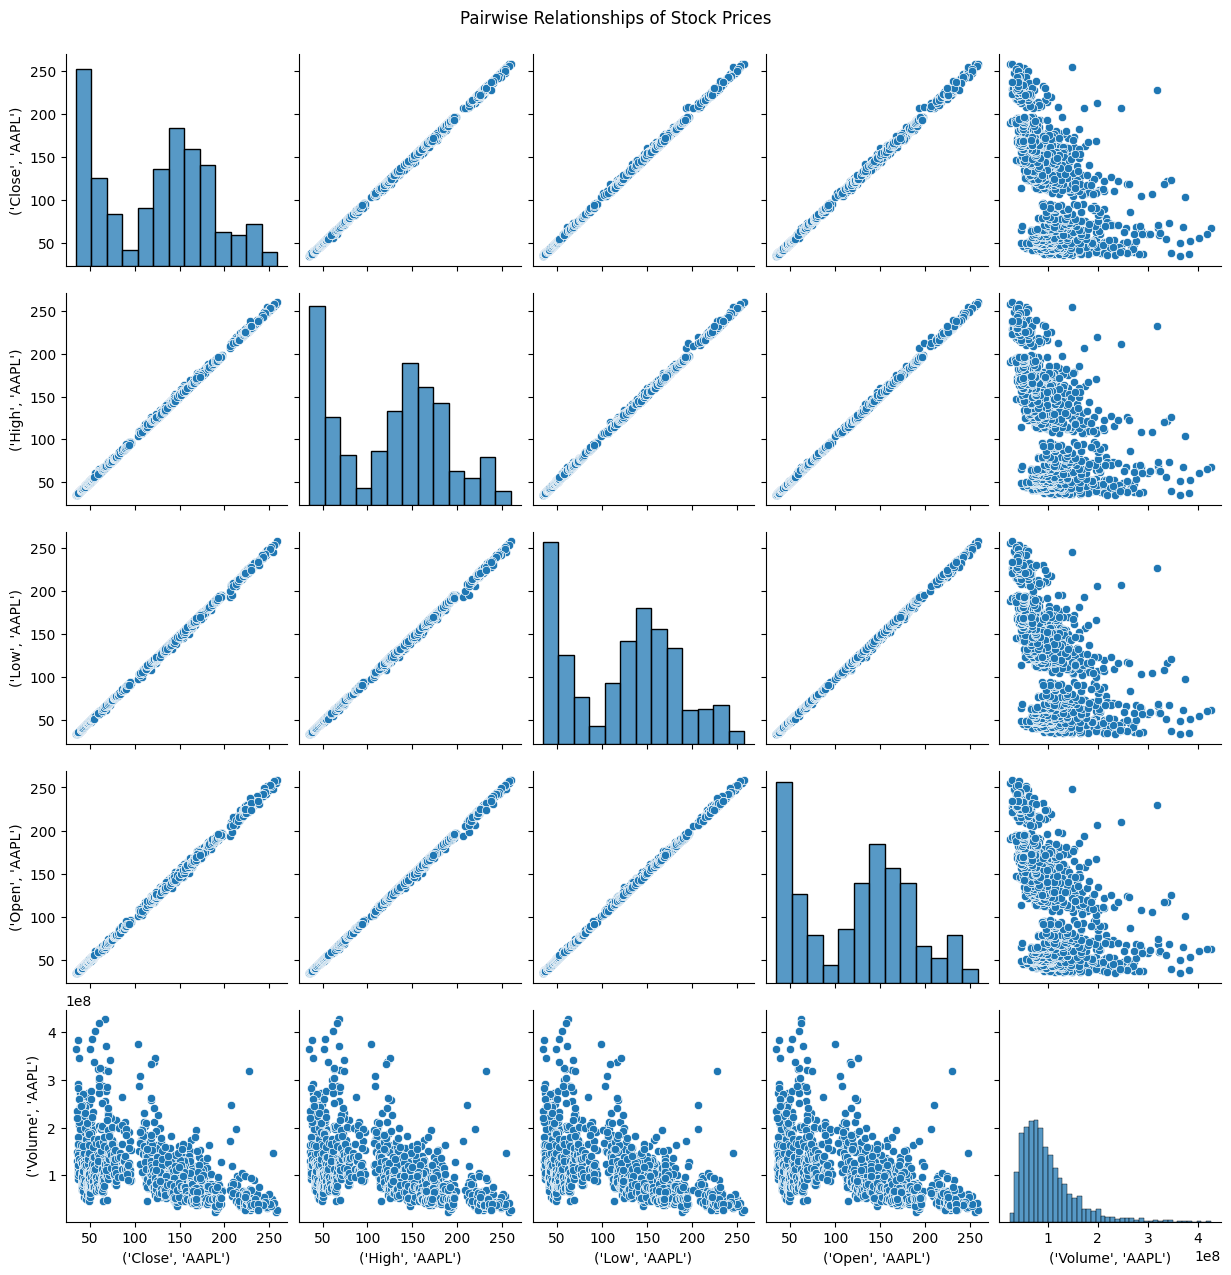

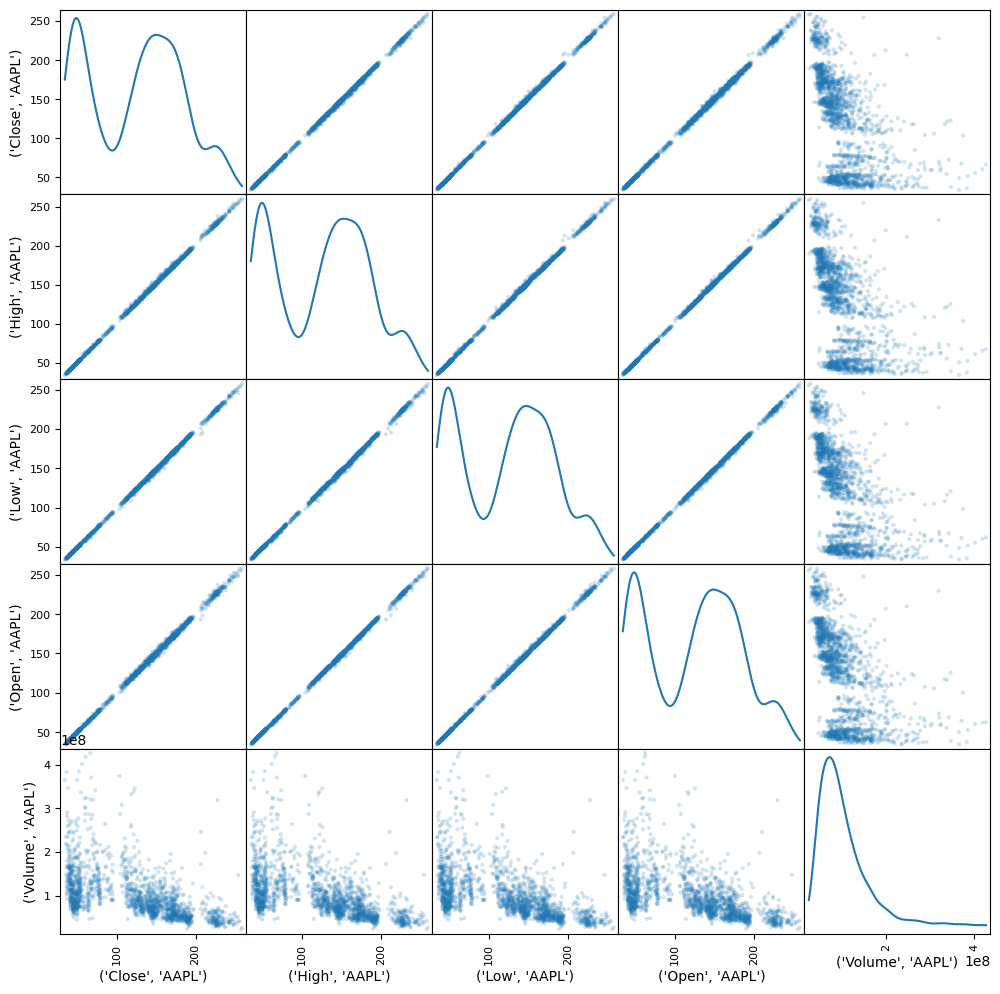

In [22]:
# prompt: generate multivariate plots

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()


# Pair plot
sns.pairplot(df)
plt.suptitle('Pairwise Relationships of Stock Prices', y=1.02)
plt.show()

# Scatter plot matrix (alternative to pairplot)
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

## Data Pre-processing

### Outlier detection

In [131]:
# Code to be used checking for outliers.
Q1 = df.quantile(0.25)  # The 25th percentile.
Q3 = df.quantile(0.75)  # The 75th percentile.

IQR = Q3 - Q1           # Inter Quantile Range (75th perentile - 25th percentile)

lower = Q1 - 1.5 * IQR  # Finding the lower bounds for all values. All values outside these bounds are outliers.
upper = Q3 + 1.5 * IQR  # Finding the upper bounds for all values. All values outside these bounds are outliers.

In [132]:
# Checking the percentages of outliers, as defined by the previous cell.
((df.select_dtypes(include=["float64", "int64"]) < lower)
    |(df.select_dtypes(include=["float64", "int64"]) > upper)
).sum() / len(data) * 100

,0
Price,
Close,0.000
High,0.000
Low,0.000
Open,0.000
Volume,4.486


* It was determined not to remove outliers since it is such a small subset of the data

### Add target_close column


In [133]:
# Create a shifted 'Close' column for the target variable
df['Target_Close'] = df['Close'].shift(-1)

In [134]:
# Drop the last row (which will have NaN in 'Target_Close')
df = df[:-1]

In [135]:
df.head()

Price,Close,High,Low,Open,Volume,Target_Close
Date,,,,,,
2018-01-29,39.513,40.030,39.303,40.030,202561600,39.280
2018-01-30,39.280,39.374,38.746,38.941,184192800,39.388
2018-01-31,39.388,39.626,39.169,39.256,129915600,39.470
2018-02-01,39.470,39.668,39.230,39.327,188923200,37.758
2018-02-02,37.758,39.240,37.664,39.052,346375200,36.814


In [136]:
# Checking the data frame for null values.
if df.isnull().values.any():
  print("There are null values.")
else:
  print("There are no null values.")

There are no null values.


### Test-train split

In [137]:
X = df.drop(columns=['Close'])
y = df['Target_Close']

In [138]:
# Splitting data into training and temp data frames.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=1)

In [139]:
# Splitting temp data frame into validation and test data frames.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=1)

In [140]:
# Printing the size of the Training, Validation, and Test data frames.
print("*"*40)
print("Shape of Training Set : ", X_train.shape)
print("Shape of Validation Set", X_val.shape)
print("Shape of Test Set : ", X_test.shape)
print("*"*40)

****************************************
Shape of Training Set :  (880, 5)
Shape of Validation Set (528, 5)
Shape of Test Set :  (352, 5)
****************************************


### Model Building

In [141]:
# Train the Model (Random Forest Example)
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

Mean Squared Error: 0.1396679361632313
R-squared: 0.9999599714062726
Comparison of predicted vs actual values:
            Actual  Predicted
Date                         
2019-09-05  51.533     51.471
2023-10-31 172.894    172.869
2024-06-13 212.011    213.407
2022-02-25 162.666    162.648
2020-02-27  66.412     66.718
2019-08-12  50.497     50.450
2023-11-07 181.759    181.662
2022-04-04 172.458    172.432
2024-06-07 192.685    193.199
2025-01-10 234.400    235.049
2018-10-31  52.878     52.937
2018-08-16  51.774     51.735
2023-12-20 193.731    196.082
2022-12-20 134.040    133.802
2024-03-26 172.685    172.736
2023-01-05 128.271    128.031
2020-01-16  77.251     77.169
2021-05-20 123.044    122.912
2022-10-05 143.678    143.446
2019-08-20  51.383     51.385


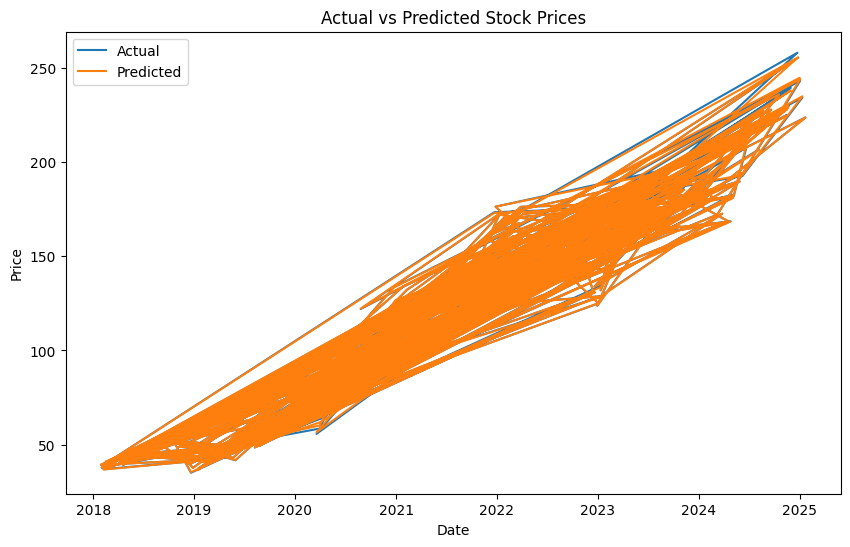

In [142]:
# prompt: compare y_pred with actual y values

from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#Further analysis and comparison
print("Comparison of predicted vs actual values:")
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df.head(20)) #Print the first 20 for example

#Visualization (optional but recommended)
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()